# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup posts on a variety of topics. You'll train classifiers to distinguish posts by topics inferred from the text. Whereas with digit classification, where each input is relatively dense (represented as a 28x28 matrix of pixels, many of which are non-zero), here each document is relatively sparse (represented as a bag-of-words). Only a few words of the total vocabulary are active in any given document. The assumption is that a label depends only on the count of words, not their order.

The `sklearn` documentation on feature extraction may be useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on Slack, but <b> please prepare your own write-up with your own code. </b>

In [3]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

Load the data, stripping out metadata so that only textual features will be used, and restricting documents to 4 specific topics. By default, newsgroups data is split into training and test sets, but here the test set gets further split into development and test sets.  (If you remove the categories argument from the fetch function calls, you'd get documents from all 20 topics.)

In [4]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test  = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels   = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels     = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('dev label shape:',      dev_labels.shape)
print('test label shape:',     test_labels.shape)
print('labels names:',         newsgroups_train.target_names)

training label shape: (2034,)
dev label shape: (676,)
test label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### Part 1:

For each of the first 5 training examples, print the text of the message along with the label.

In [5]:
def P1(num_examples=5):
    ### STUDENT START ###

    for i in range(num_examples):                
        lbls = newsgroups_train.target_names[train_labels[i]]
        print ('\t=== TRAINING EXAMPLE',i,' === ')
        print (train_data[i])
        print ('\t=== LABELLED AS "{0}. === \n\n\n'.format(lbls))

### STUDENT END ###

P1(5)

	=== TRAINING EXAMPLE 0  === 
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
	=== LABELLED AS "comp.graphics. === 



	=== TRAINING EXAMPLE 1  === 


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrat

### Part 2:

Transform the training data into a matrix of **word** unigram feature vectors.  What is the size of the vocabulary? What is the average number of non-zero features per example?  What is the fraction of the non-zero entries in the matrix?  What are the 0th and last feature strings (in alphabetical order)?<br/>
_Use `CountVectorization` and its `.fit_transform` method.  Use `.nnz` and `.shape` attributes, and `.get_feature_names` method._

Now transform the training data into a matrix of **word** unigram feature vectors using your own vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"].  Confirm the size of the vocabulary. What is the average number of non-zero features per example?<br/>
_Use `CountVectorization(vocabulary=...)` and its `.transform` method._

Now transform the training data into a matrix of **character** bigram and trigram feature vectors.  What is the size of the vocabulary?<br/>
_Use `CountVectorization(analyzer=..., ngram_range=...)` and its `.fit_transform` method._

Now transform the training data into a matrix of **word** unigram feature vectors and prune words that appear in fewer than 10 documents.  What is the size of the vocabulary?<br/>
_Use `CountVectorization(min_df=...)` and its `.fit_transform` method._

Now again transform the training data into a matrix of **word** unigram feature vectors. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?<br/>
_Hint: Build vocabularies for both train and dev and look at the size of the difference._

Notes:
* `.fit_transform` makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").
* `.fit_transform` and `.transform` return sparse matrix objects.  See about them at http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html.  

In [7]:
def P2():
    ### STUDENT START ###

    print('(1) What is the size of the vocabulary? What is the average number of non-zero features per example?' \
          'What is the fraction of the non-zero entries in the matrix? What are the 0th and last feature strings (in alphabetical order)? \n')
    
    cvec = CountVectorizer()
    feature = cvec.fit_transform(raw_documents=train_data)
    size_of_vocabulary =  feature.shape[1]
    print ('--- The size of the vocabulary {0}.'.format(size_of_vocabulary))

    feature_array = feature.toarray()
    if len(np.nonzero(feature_array.sum(axis=0))[0]) != feature.shape[1]:
        print ('--- A column of zeros: At least one feature in the vocabulary does not appear in the training set')

    average_num_of_non_zero =  feature.nnz / float(len(train_data))       
    print ('--- The average number of non-zero features per example is {0:.3f}.'.\
        format(average_num_of_non_zero))

 
           
    len(np.nonzero(feature)[0]) / float(len(train_data))
    nnz_feature = np.array([feature[i].nnz for i in range(len(train_data))])
    nnz_feature.mean()
    fraction = 100*float(feature.nnz) / (feature.shape[0]*feature.shape[1])
    print ('--- The fraction of the non-zero entries in the matrix is {0:.3f}% .'.\
        format(fraction))
    feature_strings = cvec.get_feature_names()
    feature_strings.sort()
    print ('--- The 0th feature string is "{0}"'.format(feature_strings[0]))
    print ('--- The last feature string is "{0}"'.format(feature_strings[-1]))
    print ()
    
    print('(2) Confirm the size of the vocabulary. What is the average number of non-zero features per example?\n')

    myvocab = ["atheism", "graphics", "space", "religion"]
    cvec_myvocab = CountVectorizer(vocabulary=myvocab)
    feature_myvocab = cvec_myvocab.transform(raw_documents=train_data)
    average_num_of_non_zero = feature_myvocab.nnz / float(len(train_data))
    print ('--- The size of the vocabulary:', feature_myvocab.shape)
    print ('--- The average number of non-zero features per example is {0:.3f}.'. format( average_num_of_non_zero))
    
  

    print('\n\n(3) Now transform the training data into a matrix of character bigram and trigram feature vectors. What is the size of the vocabulary?\n')
      
    cvec_ngram = CountVectorizer(analyzer='char', ngram_range=(2,3))
    feature_ngram = cvec_ngram.fit_transform(raw_documents=train_data)
    print
    print ('--- The size of the vocabulary when extracting bigram and trigram character ' \
          'features is {0}.'.format(feature_ngram.shape[1]))

         
    print('\n\n(4) Now transform the training data into a matrix of word unigram feature vectors and prune words that appear in fewer than 10 documents. What is the size of the vocabulary?\n')
    
    cvec_prune = CountVectorizer(min_df=10)
    feature_prune = cvec_prune.fit_transform(raw_documents=train_data)
    print ('---The size of the vocabulary when pruning words that appear in fewer than 10 ' \
          'documents is {0}.'.format(feature_prune.shape[1]))

    print('\n\n(5) Now again transform the training data into a matrix of word unigram feature vectors. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?\n' )
    
    fraction = 100*float(len(set(cvec.fit(raw_documents=dev_data).get_feature_names()) - 
                             set(cvec.fit(raw_documents=train_data).get_feature_names())))/len(set(cvec.fit(raw_documents=dev_data).get_feature_names()))
        
    print ('---The fraction of words in the development vocabulary that is missing from the training vocabulary is {0:.2f}% '.\
        format(fraction))
 
### STUDENT END ###
    

P2()

(1) What is the size of the vocabulary? What is the average number of non-zero features per example?What is the fraction of the non-zero entries in the matrix? What are the 0th and last feature strings (in alphabetical order)? 

--- The size of the vocabulary 26879.
--- The average number of non-zero features per example is 96.706.
--- The fraction of the non-zero entries in the matrix is 0.360% .
--- The 0th feature string is "00"
--- The last feature string is "zyxel"

(2) Confirm the size of the vocabulary. What is the average number of non-zero features per example?

--- The size of the vocabulary: (2034, 4)
--- The average number of non-zero features per example is 0.268.


(3) Now transform the training data into a matrix of character bigram and trigram feature vectors. What is the size of the vocabulary?

--- The size of the vocabulary when extracting bigram and trigram character features is 35478.


(4) Now transform the training data into a matrix of word unigram feature vecto

### Part 3:

Transform the training and development data to matrices of word unigram feature vectors.

1. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score.  For each model, show the k value and f1 score.
1. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score.  For each model, show the alpha value and f1 score.
1. Produce several Logistic Regression models by varying L2 regularization strength (C), including one with C set approximately to optimize f1 score.  For each model, show the C value, f1 score, and sum of squared weights for each topic.

* Why doesn't k-Nearest Neighbors work well for this problem?
* Why doesn't Logistic Regression work as well as Naive Bayes does?
* What is the relationship between logistic regression's sum of squared weights vs. C value?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer` and its `.fit_transform` and `.transform` methods to transform data.
* You can use `KNeighborsClassifier(...)` to produce a k-Nearest Neighbors model.
* You can use `MultinomialNB(...)` to produce a Naive Bayes model.
* You can use `LogisticRegression(C=..., solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.

In [9]:
def P3():
    ### STUDENT START ###
    
    import warnings
    warnings.filterwarnings('ignore')
    cvec = CountVectorizer()
    feature_vectors_train = cvec.fit_transform(raw_documents=train_data)
    feature_vectors_dev = cvec.transform(raw_documents=dev_data)

    
    #======== kNN ========#
    
    print ('k Nearest Neighbors:')
    print ('--------------------')
    f1 = []
    param = np.arange(1,30,1)
    for k in param: 
        kNN_model = KNeighborsClassifier(n_neighbors = k)
        kNN_model.fit(feature_vectors_train, train_labels)
        dev_predicted_labels = kNN_model.predict(feature_vectors_dev)
        
        f1_score = metrics.f1_score(y_true=dev_labels, y_pred=dev_predicted_labels,average='macro')
        f1.append(f1_score) 
        print ('k=', k, '  f1_score=',f1_score )         
    
    
    max_f1_score = max(f1).round(4)
    optimal_k = f1.index(max(f1))+1
    
    
    print ('When k =', optimal_k, 'maxmum F1 score for the kNN classifier is', max_f1_score, '\n\n\n')
P3()

k Nearest Neighbors:
--------------------
k= 1   f1_score= 0.3689323577122323
k= 2   f1_score= 0.3632393463992087
k= 3   f1_score= 0.3942754348634139
k= 4   f1_score= 0.39131940574852586
k= 5   f1_score= 0.4146398917578007
k= 6   f1_score= 0.43346659872073223
k= 7   f1_score= 0.43709301301130393
k= 8   f1_score= 0.4342402721490597
k= 9   f1_score= 0.42330050510183215
k= 10   f1_score= 0.41341807187900614
k= 11   f1_score= 0.4127564818226528
k= 12   f1_score= 0.4080241241655858
k= 13   f1_score= 0.40885223308041974
k= 14   f1_score= 0.40819918242594844
k= 15   f1_score= 0.4191105719405859
k= 16   f1_score= 0.41853560250964866
k= 17   f1_score= 0.43385309500398517
k= 18   f1_score= 0.4167720818163296
k= 19   f1_score= 0.4212330134242338
k= 20   f1_score= 0.41035252840465025
k= 21   f1_score= 0.41256886912559737
k= 22   f1_score= 0.3942826372289844
k= 23   f1_score= 0.3943185234807286
k= 24   f1_score= 0.38986420718062553
k= 25   f1_score= 0.40075005178483564
k= 26   f1_score= 0.403345682

k Nearest Neighbors:
--------------------
k= 1   f1_score= 0.3689323577122323
k= 2   f1_score= 0.3632393463992087
k= 3   f1_score= 0.3942754348634139
k= 4   f1_score= 0.39131940574852586
k= 5   f1_score= 0.4146398917578007
k= 6   f1_score= 0.43346659872073223
k= 7   f1_score= 0.43709301301130393
k= 8   f1_score= 0.4342402721490597
k= 9   f1_score= 0.42330050510183215
k= 10   f1_score= 0.41341807187900614
k= 11   f1_score= 0.4127564818226528
k= 12   f1_score= 0.4080241241655858
k= 13   f1_score= 0.40885223308041974
k= 14   f1_score= 0.40819918242594844
k= 15   f1_score= 0.4191105719405859
k= 16   f1_score= 0.41853560250964866
k= 17   f1_score= 0.43385309500398517
k= 18   f1_score= 0.4167720818163296
k= 19   f1_score= 0.4212330134242338
k= 20   f1_score= 0.41035252840465025
k= 21   f1_score= 0.41256886912559737
k= 22   f1_score= 0.3942826372289844
k= 23   f1_score= 0.3943185234807286
k= 24   f1_score= 0.38986420718062553
k= 25   f1_score= 0.40075005178483564
k= 26   f1_score= 0.403345682

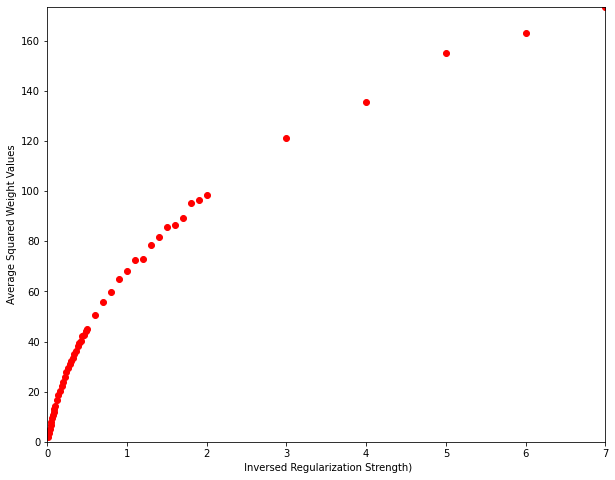

In [8]:
def P3():
    ### STUDENT START ###
    
    import warnings
    warnings.filterwarnings('ignore')
    cvec = CountVectorizer()
    feature_vectors_train = cvec.fit_transform(raw_documents=train_data)
    feature_vectors_dev = cvec.transform(raw_documents=dev_data)

    
    #======== kNN ========#
    
    print ('k Nearest Neighbors:')
    print ('--------------------')
    f1 = []
    param = np.arange(1,30,1)
    for k in param: 
        kNN_model = KNeighborsClassifier(n_neighbors = k)
        kNN_model.fit(feature_vectors_train, train_labels)
        dev_predicted_labels = kNN_model.predict(feature_vectors_dev)
        
        f1_score = metrics.f1_score(y_true=dev_labels, y_pred=dev_predicted_labels,average='macro')
        f1.append(f1_score) 
        print ('k=', k, '  f1_score=',f1_score )         
    
    max_f1_score = max(f1).round(4)
    optimal_k = f1.index(max(f1))
         
    print ('When k =', optimal_k, 'maxmum F1 score for the kNN classifier is', max_f1_score, '\n\n\n')

 
    #======== MultinomialNB ========#
        
    print ('\nMultinomial Naive Bayes:')
    print ('=============================')
    # Let's try values of alpha up to 1
    alpha = np.concatenate([np.arange(0,0.01,0.002),np.arange(0.01,0.1,0.01),
                            np.arange(0.1,1.1,0.1)])
 
    
    f1 = []

    for al in alpha: 
        NB_model = MultinomialNB(alpha=al)
        NB_model.fit(feature_vectors_train, train_labels)
        dev_predicted_labels = NB_model.predict(feature_vectors_dev)
        
        f1_score = metrics.f1_score(y_true=dev_labels, y_pred=dev_predicted_labels,average='macro')
        
        al = al.round(4)
        f1.append((al, f1_score)) 
        
        print ('alpha=', al, '  f1_score=',f1_score )         
    
    df = pd.DataFrame(f1, columns=['alpha', 'f1_score'])
    max_f1_score = df.loc[:,'f1_score'].max()
    index = df['f1_score'].idxmax() 
    optimal_alpha = df.at[index,'alpha']
        
    print ('When alpha =', optimal_alpha, 
           ', maxmum F1 score for the MultinomialNB classifier is', max_f1_score, '\n\n\n')
        
  
    #======== Logistic Regression ========#
    
    print ('\nLogistic Regression:')
    print ('==========================')

    inv_regul_str = np.concatenate([np.arange(0.01,0.1,0.01),np.arange(0.1,0.5,0.02),
                                    np.arange(0.5,2,0.1),np.arange(2,8,1)])

    f1 = []

    for cval in inv_regul_str: 
        LR_model = LogisticRegression(penalty='l2', C=cval)
        LR_model.fit(feature_vectors_train, train_labels)
        dev_predicted_labels = LR_model.predict(feature_vectors_dev)
 
        
        f1_score = metrics.f1_score(y_true=dev_labels, y_pred=dev_predicted_labels,average='macro')
        
        cval = cval.round(4)
        f1.append((cval, f1_score)) 
        
        print ('CValue=', cval, '  f1_score=',f1_score )         
    
    df = pd.DataFrame(f1, columns=['CValue', 'f1_score'])
    print(df)
    max_f1_score = df.loc[:,'f1_score'].max()
    index = df['f1_score'].idxmax() 
    optimal_c = df.at[index,'CValue']
        
    print ('When C Value =', optimal_c, 
           ', maxmum F1 score for the Logistic Regression classifier is', max_f1_score, '\n\n\n')
    
    
    squared_sum = np.zeros(4*inv_regul_str.shape[0]).reshape(inv_regul_str.shape[0],4)
    for i,c in enumerate(inv_regul_str):
        LR_model = LogisticRegression(penalty='l2', C=c)
        LR_model.fit(feature_vectors_train, train_labels)
        squared_sum[i,:] = np.square(LR_model.coef_).sum(axis=1)

    squared_sum_short = squared_sum[4::5,:]
    inv_regul_str_short = inv_regul_str[4::5]
    classes = [c.rjust(18) for c in newsgroups_train.target_names]

    classes.insert(0, 'features')
    t2 = []
    t2.append(classes)
    for i in range(10):
        t2.append([inv_regul_str_short[i], squared_sum_short[i,0], squared_sum_short [i,1],
                      squared_sum_short [i,2], squared_sum_short [i,3]])
    tb =  pd.DataFrame(t2)
    tb.columns = [''] * len(tb.columns)
    print('==============')
    print(tb.to_string(index=False))


    squared_sum_mean = squared_sum[:,1:].mean(axis=1)
    plt.figure(figsize=(10, 8))
    plt.scatter(inv_regul_str, squared_sum_mean, c='red')
    plt.xlabel(" Inversed Regularization Strength)")
    plt.ylabel("Average Squared Weight Values")
    plt.ylim([0, squared_sum_mean.max()])
    plt.xlim([0, inv_regul_str.max()])

### STUDENT END ###
       
P3()

ANSWER:


#### Q4:  Why doesn't k-Nearest Neighbors work well for this problem?

Firstly, it is important for KNN model to measure the weight of neighbors, so that the weight of the closer neighbor is greater than the weight of the far neighbor. However,  in this poblem we assigned the same weight to all the features in the training set. In this work, all training samples and testing samples share many unweighted common words that causes the distance between any pair of sample to be similar, without taking case of their topics, which will cause many predictions to be inaccurate . The solution is to give more weight to the words related to the topic, rather than to the frequency of the common words.

Secondly, the kNN model is based on a measure of proximity/similarity, based on the characteristics of the items (acting as coordinates or dimensions). In K-NN learning, local approximation and all calculations are postponed until classification.  The neighbors are all taken from a set of objects that have been correctly classified.  The disadvantage of the k-nearest neighbor algorithm is that it is very sensitive to the local structure of the data. In topic classification, the challenge is that the number of features defining the space is almost unlimited, but we train our model with a very limited number of features: the features present in the example are taken from the training set. Therefore, we have omitted many other dimensions.

 
 
#### Q5: Why doesn't Logistic Regression work as well as Naive Bayes does?
 

In general, NB (a generative model) has greater bias but lower variance than Logistic Regression (a discriminative model). Both lower bias and higher variance are needed to get better predictions: bias (which is related to underfitting) is what causes error rate in both the training set and the dev set to be high (and roughly equal); variance (which is related to overfitting) is what causes the error rate in the dev set to increase while the error rate in the training set keeps decreasing, and hence it's a problem when the model is too complex, given a fixed dataset size.**

Bias appears in NB models when NB assumptions are not met (mainly, the conditional independence assumption, that states that the features are independent of each other given the class; e.g., given that a document is about *space*, "*launch*" and "*spacecraft*" are independent of each other). (Some sources mention that, provided the NB assumptions hold, NB and Logistic Regression and Naive Bayes perform almost identically as the number of training examples approaches infinity.)**

The fact that Logistic Regression doesn't work as well as NB suggests that the bias of the latter is not as large as the higher variance of Logistic Regression. I.e., it seems that the conditional independence assumption holds, even though that doesn't seem correct in text classification (words are highly dependent of each other). The truth is that the assumption is broken, but that's not a big deal—of course, the probability estimates will be inaccurate, but it's how they compare to each other what we care about (i.e., which class gets the highest score), so the decisions will be good.**

To put an example, let's remember that:**

**$$P(\text{class} \mid \text{features}) = \frac{P(\text{features} \mid \text{class}) \cdot P(\text{class})}{\sum_{\forall \text{class}} P(\text{features} \mid \text{class}) \cdot P(class)}$$**

Suppose the dev example we want to classify has a set of features $f$: most of the features are typical in *atheism* but not in the other topics. To simplify the example, let's assume the only other topic is *graphics*. That means that $P(f \mid \text{atheism})$ will be much greater than $P(f \mid \text{graphics})$, causing $P(\text{atheism} \mid f)$ to be much greater than $P(\text{graphics} \mid f)$. These two probability estimates will be inaccurate (in many cases, the former will be close to 1 and the latter close to 0), but what matters—when it makes to classifying—is not what their values are, but simply that $P(\text{atheism} \mid f) > P(\text{graphics} \mid f)$.**

On the other hand, variance is a problem in Logistic Regression because the model is *too complex*. We can approximate the complexity as the ratio of features and training examples: we have so many features, compared to the number of training examples, that variance becomes a problem and makes Logistic Regression perform worse than NB. If we had more training examples (although that might involve more features too, in text classification), Logistic Regression would perform better than Naive Bayes (that works better with less training data, as the estimates are based on joint probabilities).**
 



#### Q6: What is the relationship between logistic regression's sum of squared weights vs. C value?


As shown in the plot above, it looks like the relationship between the sum—its average value for the 4 classes has been plotted, but the graph would not look very different for each particular class—and the value of C can be approximated as $k \cdot C^{\alpha}$, where $k$ and $\alpha$ are constants, with $\alpha < 1$.**

This is coherent with the fact that *smaller values (of C) specify stronger regularization*, so as C approaches zero, all the coefficients (for any class) also approach zero, resulting in:**

**$$P(Y \mid \theta) = \frac{1}{1+e^{-\theta}} \rightarrow \frac{1}{1+e^0} = \frac{1}{2}$$**

I.e., as expected a very strong regularization leads to the null model, in which we are uncertain about the category and assign a 50% likelihood to any of them (the classification may be seem as random). On the other hand, as we penalize less and less (the complexity of the model), the sum of the squared weight values increases, and so do the relevance of the features. But it is important to note that it's the *absolute* values (because we are squaring them) which increase: the features that are common in a topic will have positive values, leading to an increase in the likelihood of belonging to that topic if the example we want to classify have those features; on the other hand, features that are not so common in a given topic may be great in absolute value, but will be negative, thus decreasing an example's likelihood of belonging to that topic if that example have those features.**


### Part 4:

Transform the data to a matrix of word **bigram** feature vectors.  Produce a Logistic Regression model.  For each topic, find the 5 features with the largest weights (that's 20 features in total).  Show a 20 row (features) x 4 column (topics) table of the weights.

Do you see any surprising features in this table?

Notes:
* Train on the transformed training data.
* You can use `CountVectorizer` and its `.fit_transform` method to transform data.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `np.argsort` to get indices sorted by element value. 

In [26]:
def P4():
    ### STUDENT START ###
    
    def table(CV):
        feature_vectors = CV.fit_transform(raw_documents=train_data)
        LR_model = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
        LR_model.fit(feature_vectors, train_labels)
 
        part = np.argpartition(LR_model.coef_, -5)[:,-5:]
        for i in range(len(newsgroups_train.target_names)):
            part[i,:] = part[i, np.argsort(np.take(LR_model.coef_[i,:], part[i,:]))[::-1]]

        part = part.flatten()
        weights = np.take(LR_model.coef_, part, axis=1).T
        word_features = CV.get_feature_names()

        main_features = np.empty(20).astype('str')
        for i in range(part.shape[0]):
            main_features[i] = word_features[part[i]].ljust(14)
        classes = [c.rjust(18) for c in newsgroups_train.target_names]
        classes.insert(0, 'features')
        t2 = []
        t2.append(classes)
        for i in range(20):
            f = main_features[i]
            t2.append([f, weights[i,0], weights[i,1], weights[i,2], weights[i,3]])
        tb =  pd.DataFrame(t2)
        tb.columns = [''] * len(tb.columns)
        print('==============')
        print(tb.to_string(index=False))
 
    table(CountVectorizer(analyzer='word', ngram_range=(2,2)))

    
### STUDENT END ###

P4()

                                                                                               
       features         alt.atheism       comp.graphics           sci.space  talk.religion.misc
 claim that                0.605549           -0.199053           -0.274355           -0.140364
 cheers kent               0.555719           -0.697903           -0.663773            0.534808
 was just                   0.48205            -0.13143           -0.128896           -0.227466
 you are                   0.472741           -0.279878           -0.481324            0.028371
 are you                   0.446954           -0.248269           -0.097147           -0.305623
 looking for              -0.630341             1.10837           -0.499971           -0.571862
 in advance               -0.459351            0.832567           -0.438511           -0.418455
 comp graphics            -0.292166            0.801222           -0.370896           -0.285185
 out there                -0.274802     

ANSWER:

**The 2 tables look rather different, but that's not surprising at all.**

**When we use words, the model makes a relatively good work finding the ones that are most frequent in a topic and less in the others. Hence, we see that the weight values for those *top 5* features have a relatively large positive value for the corresponding class (e.g., 0.66 for "*computer*" associated with *graphics*), and a large absolute value, but negative, for the other classes (e.g., see the weights of "*computer*" for the other 3 classes; it's only close to 0 for *atheism*; also note that the same happens with the word "*religion*:" 0.59 for *atheism*, -0.26 for both *graphics* and *space*, and close to 0 for *religion*). I.e., the presence of those features increase significantly the likelihood of being part of that class, and also the likelihood of not being part of the others.**

**When we use bigrams, it is unrare that two words associated with one topic—and not the others—appear together (e.g., "*nasa orbit*" or "*computer 3d*"). Exceptions are "*the moon*" or "*the space*," and do note that their weight values are large for *space* and large in absolute value but negative for the other 3 classes. In general, typical bigrams are like the ones that are shown in the 2nd table: "*in this*," "*out there*," or "*and such*." They are not exclusive of a certain topic, and hence it's not so unlikely to find some in training examples of other topics: that causes that the weight values, when positive, are not so great (most of them are between 0.3 and 0.5 instead of between 0.5 and 0.8, as it occurred in the 1st table), and when they are negative (i.e., the weight values for a bigram when inspecting the likelihood of a different class), they are also not great in absolute value. Exceptions are "*the moon*" or "*the space*," as mentioned, but look for example at "*the fbi*" or "*the word*."**

### Part 5:

To improve generalization, it is common to try preprocessing text in various ways before splitting into words. For example, you could try transforming strings to lower case, replacing sequences of numbers with single tokens, removing various non-letter characters, and shortening long words.

Produce a Logistic Regression model (with no preprocessing of text).  Evaluate and show its f1 score and size of the dictionary.

Produce an improved Logistic Regression model by preprocessing the text.  Evaluate and show its f1 score and size of the vocabulary.  Try for an improvement in f1 score of at least 0.02.

How much did the improved model reduce the vocabulary size?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer(preprocessor=...)` to preprocess strings with your own custom-defined function.
* `CountVectorizer` default is to preprocess strings to lower case.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.
* If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular.

In [27]:
 

def better_preprocessor(s):
    ### STUDENT START ###
    s = re.sub("[^A-Za-z0-9 \\n]", " ", s)
    s = re.sub("(\w{%d})\w+" % 5, "\\1", s)
    s = re.sub("([\d]+)", " number ", s)
    s = s.lower()

    return s

    ### STUDENT END ###
       
    
def P5():
    ### STUDENT START ###

    def no_preprocessing(data):
        return data
    
    def preprocessing(data):
        feature_vectors_train = data.fit_transform(raw_documents=train_data)
        feature_vectors_dev = data.transform(raw_documents=dev_data)
        LR_model = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
        LR_model.fit(feature_vectors_train, train_labels)
        dev_predicted_labels = LR_model.predict(feature_vectors_dev)
        f1_score = metrics.f1_score(y_true=dev_labels, y_pred=dev_predicted_labels, average='weighted')
        return [feature_vectors_train.shape[1], f1_score]

    [size_original, F1_original] = preprocessing(CountVectorizer(preprocessor 
                                                                 = no_preprocessing)) 
    print ('F1 score of using empty_preprocessor: {0:.4f}\n'.format(F1_original))

    [size_better, F1_better] = preprocessing(CountVectorizer(preprocessor 
                                                             = better_preprocessor,stop_words='english'))     
    print ('F1 score of using better_preprocessor: {0:.4f}\n'.format(F1_better))
    
    improvement = F1_better-F1_original
    print ('Better_preprocessor impoves empty_preprocessor in F1 score by {0:.4f}\n'.format(improvement))
    
    reduce = 100*float(1-(size_better)/size_original)
    print ('The size of the dictionary with better_preprocessor has ' 
           'reduced {0:.1f}% of the size of original_preprocessor.'.format(reduce))

    ### STUDENT END ###

P5()

F1 score of using empty_preprocessor: 0.7069

F1 score of using better_preprocessor: 0.7361

Better_preprocessor impoves empty_preprocessor in F1 score by 0.0292

The size of the dictionary with better_preprocessor has reduced 57.6% of the size of original_preprocessor.


### Part 6:

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. Logistic regression seeks the set of weights that minimizes errors in the training data AND has a small total size. The default L2 regularization computes this size as the sum of the squared weights (as in Part 3 above). L1 regularization computes this size as the sum of the absolute values of the weights. Whereas L2 regularization makes all the weights relatively small, L1 regularization drives many of the weights to 0, effectively removing unimportant features.

For several L1 regularization strengths ...<br/>
* Produce a Logistic Regression model using the **L1** regularization strength.  Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.  Produce a new Logistic Regression model using the reduced vocabulary and **L2** regularization strength of 0.5.  Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.

Show a plot of f1 score vs. log vocabulary size.  Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.

How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `LogisticRegression(..., penalty="l1")` to produce a logistic regression model using L1 regularization.
* You can use `LogisticRegression(..., penalty="l2")` to produce a logistic regression model using L2 regularization.
* You can use `LogisticRegression(..., tol=0.015)` to produce a logistic regression model using relaxed gradient descent convergence criteria.  The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.015 (the default is .0001).

* Number of learned weights not equal to zero using a "l2" penalty: 107516
* These weights correspond to a total of 26879 features (vocabulary size)

C = 0.001
---------
* Number of learned weights not equal to zero using a "l1" penalty: 6
	(0.0% of the number using "l2")
* These weights correspond to a total of 3 features (vocabulary size)
	(0.0% of the size using "l2")
* F1 score using a "l2" penalty without pruning: 0.5042
* F1 score using a "l2" penalty after pruning:   0.3081 (38.90% lower)

C = 0.01
---------
* Number of learned weights not equal to zero using a "l1" penalty: 35
	(0.0% of the number using "l2")
* These weights correspond to a total of 17 features (vocabulary size)
	(0.1% of the size using "l2")
* F1 score using a "l2" penalty without pruning: 0.6198
* F1 score using a "l2" penalty after pruning:   0.4222 (31.88% lower)

C = 0.1
---------
* Number of learned weights not equal to zero using a "l1" penalty: 370
	(0.3% of the number using "l2")
* These weights corres

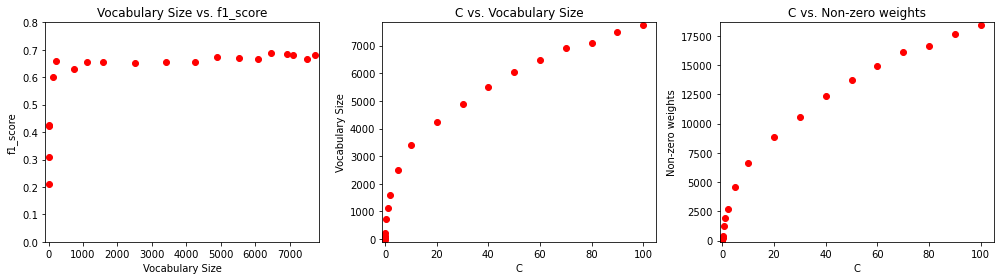

In [47]:
def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0) 
        
    ### STUDENT START ###
 
    c = np.concatenate([np.array([0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 5]),np.linspace(10,100,10)])
    f1_score = np.zeros(len(c))
    vocab_size = np.zeros(len(c)).astype('u4')
    nonzero_weights = np.zeros(len(c)).astype('u4')
    
    for i in range(len(c)):
        cvec = CountVectorizer()
        feature_vectors_train = cvec.fit_transform(raw_documents=train_data)
        feature_vectors_dev = cvec.transform(raw_documents=dev_data)

        LR_model_l1 = LogisticRegression(penalty='l1', C = c[i], tol=0.015, solver='liblinear')
        LR_model_l1.fit(feature_vectors_train, train_labels)
        vocab_size[i] = np.count_nonzero(np.apply_along_axis(np.count_nonzero, 0, LR_model_l1.coef_))
        nonzero_weights[i] = np.apply_along_axis(np.count_nonzero, 0, LR_model_l1.coef_).sum()

        mask = (LR_model_l1.coef_!=0)
        idx = mask.any(axis=0)

        feature_vectors_train_pruned = feature_vectors_train[:, idx]
        feature_vectors_dev_pruned = feature_vectors_dev[:, idx]

        LR_model_l2 = LogisticRegression(penalty='l2', C = c[i], tol=0.015)
        LR_model_l2.fit(feature_vectors_train_pruned, train_labels)
        dev_predicted_labels_pruned = LR_model_l2.predict(feature_vectors_dev_pruned)
        f1_score[i] = metrics.f1_score(y_true=dev_labels, y_pred=dev_predicted_labels_pruned,average='macro')
                

        if c[i] in [0.001, 0.01, 0.1, 1, 10, 100]:
            LR_model_l2.fit(feature_vectors_train, train_labels)
            l2_nonzero_weights = np.apply_along_axis(np.count_nonzero, 0,LR_model_l2.coef_).sum()
            l2_vocab_size = np.count_nonzero(np.apply_along_axis(np.count_nonzero, 0, LR_model_l2.coef_))
            if c[i]==0.001:
                print ('* Number of learned weights not equal to zero using a "l2" penalty: ' \
                      '{0}'.format(l2_nonzero_weights))
                print ('* These weights correspond to a total of {0} features (vocabulary ' \
                      'size)\n'.format(l2_vocab_size))


            print ('C = {0}'.format(c[i]))
            print ('---------')            
            
            print ('* Number of learned weights not equal to zero using a "l1" penalty: {0}' \
                  '\n\t({1:.1f}% of the number using "l2")'.\
                format(nonzero_weights[i], round(100.*nonzero_weights[i]/l2_nonzero_weights,2)))         
            
            print ('* These weights correspond to a total of {0} features (vocabulary size)' \
                  '\n\t({1:.1f}% of the size using "l2")'.\
                format(vocab_size[i], round(100.*vocab_size[i]/l2_vocab_size,2)))
        
            dev_predicted_labels_unpruned = LR_model_l2.predict(feature_vectors_dev)
           
            f1_score_unpruned = metrics.f1_score(y_true=dev_labels, 
                                                 y_pred=dev_predicted_labels_unpruned,average='macro')
            print ('* F1 score using a "l2" penalty without pruning: {0:.4f}'.format(f1_score_unpruned))
                       
            print ('* F1 score using a "l2" penalty after pruning:   {0:.4f} ({1:.2f}% lower)' \
                  '\n'.format(f1_score[i], round(100*(1-f1_score[i]/f1_score_unpruned),2)))

    plt.figure(figsize=(14, 4))
    ax = plt.subplot(1, 3, 1)
    plt.scatter(vocab_size, f1_score, c='red')
    plt.xlabel("Vocabulary Size")
    plt.ylabel("f1_score")
    plt.title('Vocabulary Size vs. f1_score')
    plt.xlim([-100, vocab_size.max()+100])
    plt.ylim([0, 0.8])
    ax = plt.subplot(1, 3, 2)
    plt.scatter(c, vocab_size, c='red')
    plt.xlabel("C")
    plt.ylabel("Vocabulary Size")
    plt.title('C vs. Vocabulary Size')
    plt.xlim([-1, c.max()+5])
    plt.ylim([-100, vocab_size.max()+100])

    ax = plt.subplot(1, 3, 3)
    plt.scatter(c, nonzero_weights, c='red')
    plt.xlabel("C")
    plt.ylabel("Non-zero weights")
    plt.title('C vs. Non-zero weights')
    plt.xlim([-1, c.max()+5])
    plt.ylim([-100, nonzero_weights.max()+200])
    plt.tight_layout()

    
### STUDENT END ###

P6()

ANSWER:

How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?


### Part 7:

How is `TfidfVectorizer` different than `CountVectorizer`?

Produce a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100.  Evaluate and show the f1 score.  How is `TfidfVectorizer` different than `CountVectorizer`?

Show the 3 documents with highest R ratio, where ...<br/>
$R\,ratio = maximum\,predicted\,probability \div predicted\,probability\,of\,correct\,label$

Explain what the R ratio describes.  What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

Note:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `TfidfVectorizer` and its `.fit_transform` method to transform data to tf-idf form.
* You can use `LogisticRegression(C=100, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `LogisticRegression`'s `.predict_proba` method to access predicted probabilities.

Accuracy for a Logistic Regression classifier using TfidfVectorizer: 76.33%
Percentage of incorrectly predicted labels (R>1): 23.67% (=1-Accuracy)

929.36   talk.religion.misc        comp.graphics 

325.0   talk.religion.misc        comp.graphics 

287.31          alt.atheism   talk.religion.misc 

--------------------------------------------------------
216th DOCUMENT: R = 929.36
* PREDICTED CATEGORY (prob = 0.9937): comp.graphics
* CORRECT CATEGORY   (prob = 0.0011): talk.religion.misc

I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "W

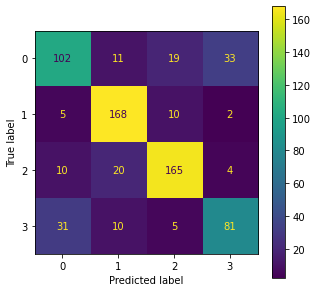

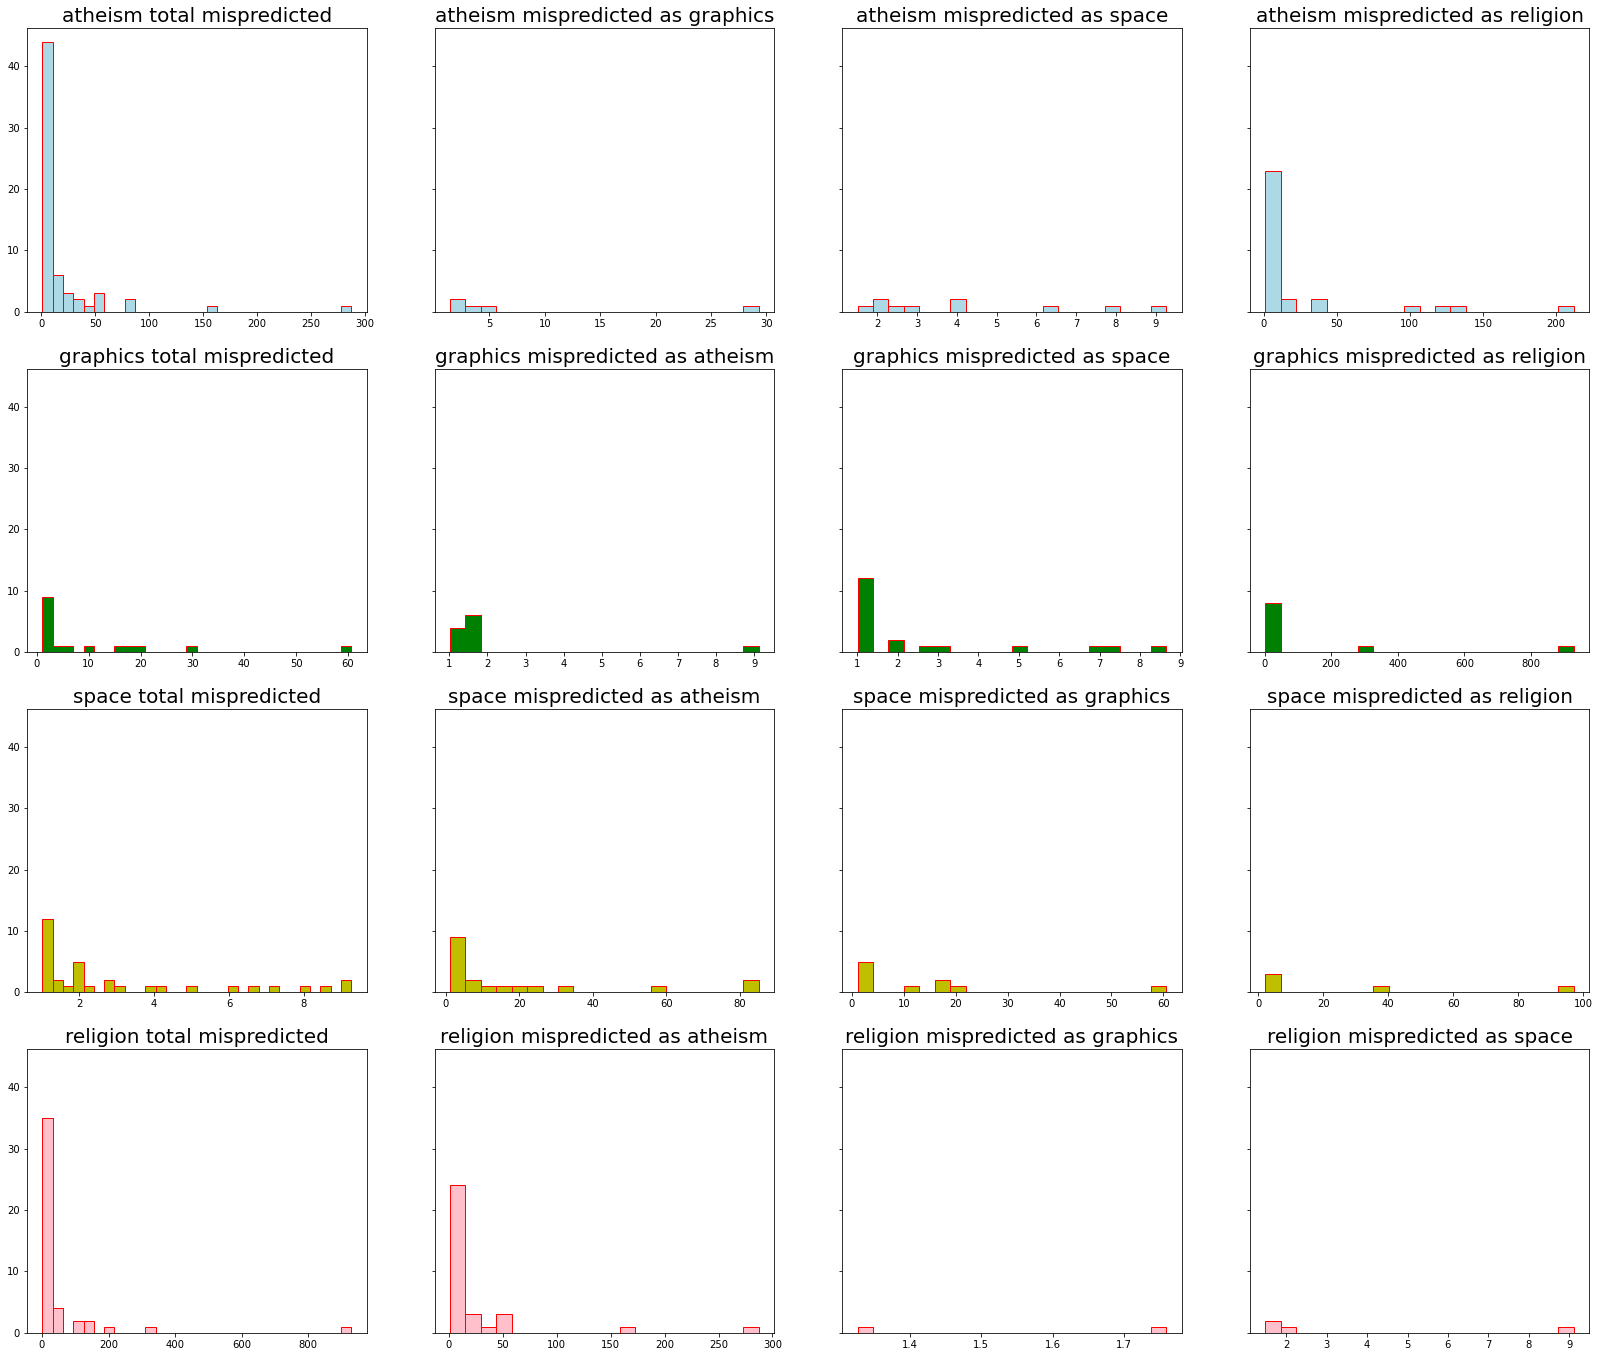

In [45]:
def P7():
### STUDENT START ###

    from sklearn.metrics import plot_confusion_matrix
    
    
    TFIDF = TfidfVectorizer()
    feature_vectors_train = TFIDF.fit_transform(raw_documents=train_data)
    LR_model = LogisticRegression( C=100, solver="liblinear", multi_class="auto")
    LR_model.fit(feature_vectors_train, train_labels)
    feature_vectors_dev = TFIDF.transform(raw_documents=dev_data)
    dev_preds = LR_model.predict(feature_vectors_dev)
 
    accuracy = 100*metrics.accuracy_score(y_true=dev_labels, y_pred=dev_preds)
    print ('Accuracy for a Logistic Regression classifier using TfidfVectorizer: {0:.2f}%'.format(accuracy))
    
    dev_probs = LR_model.predict_proba(feature_vectors_dev)
    max_prob = dev_probs.max(axis=1)
    prob_correct_label = np.array([dev_probs[i,j] for i,j in zip(range(len(dev_labels)),dev_labels)])
    R = max_prob / prob_correct_label
    percentage = 100*len(R[R>1])/float(len(R))
    print ('Percentage of incorrectly predicted labels (R>1): {0:.2f}% (=1-Accuracy)\n'.format(percentage))

    for i in (215,665, 607):
        print (R[i].round(2), newsgroups_train.target_names[dev_labels[i]].rjust(20),\
            newsgroups_train.target_names[dev_probs[i,:].argmax()].rjust(20),'\n')
    # Top 3
    doc_index = np.argpartition(R, -3)[-3:]
    # Top 3 in descending order
    doc_index = doc_index[np.argsort(R[doc_index])][::-1]
    for i,ind in enumerate(doc_index):
        print ('--------------------------------------------------------')
        print ('{0}th DOCUMENT: R = {1:.2f}'.format(ind+1, R[ind]))
        print ('* PREDICTED CATEGORY (prob = {0:.4f}): {1}'.\
            format(max_prob[ind],
                   newsgroups_train.target_names[dev_probs[ind,:].argmax()]))
        print ('* CORRECT CATEGORY   (prob = {0:.4f}): {1}\n'.\
            format(dev_probs[ind,dev_labels[ind]],
                   newsgroups_train.target_names[dev_labels[ind]]))
        print (dev_data[ind])
    
     
    
    df = pd.DataFrame(dev_labels, columns = ["dev_labels"])
    df2 = pd.DataFrame(max_prob, columns = ["max_prob"])
    df3 = pd.DataFrame(R, columns = ['R'] )
    df4 = pd.DataFrame(dev_preds, columns = ['dev_preds'] )
    df['max_prob'] =  df2['max_prob'] 
    df['R'] =  df3['R']    
    df['log_R'] = np.log(df['R'])
    df['dev_preds'] = df4['dev_preds'].astype(int)
    df['dev_labels'] = df['dev_labels'].astype(int)

    
    fig, ax = plt.subplots(figsize=(5, 5))
    plot_confusion_matrix(LR_model, feature_vectors_dev, dev_labels, ax=ax)
    plt.show()


    fig, ((ax0, ax4, ax5, ax6), (ax1, ax7, ax8, ax9), (ax2, ax10, ax11, ax12), 
          (ax3, ax13, ax14, ax15)) = plt.subplots(nrows=4, ncols=4, sharey=True, figsize=(28,24))  

    ax0.set_title('atheism total mispredicted', fontsize=20)
    ax0.hist(df[(df['dev_labels']==0) & (df['log_R']>0)]['R'],30, color = "lightblue", ec="red")
    ax1.set_title('graphics total mispredicted', fontsize=20)
    ax1.hist(df[(df['dev_labels']==1) & (df['log_R']>0)]['R'],30, color = "g", ec="red")
    ax2.set_title('space total mispredicted', fontsize=20)
    ax2.hist(df[(df['dev_labels']==2) & (df['log_R']>0)]['R'],30, color = "y", ec="red")
    ax3.set_title('religion total mispredicted', fontsize=20)
    ax3.hist(df[(df['dev_labels']==3) & (df['log_R']>0)]['R'],30, color = "pink", ec="red")
    ax4.set_title('atheism mispredicted as graphics', fontsize=20)
    ax4.hist(df[(df['dev_preds']==0) & (df['dev_labels']==1)]['R'],20, color = "lightblue", ec="red") 
    ax5.set_title('atheism mispredicted as space', fontsize=20)
    ax5.hist(df[(df['dev_preds']==0) & (df['dev_labels']==2)]['R'],20, color = "lightblue", ec="red")
    ax6.set_title('atheism mispredicted as religion', fontsize=20)
    ax6.hist(df[(df['dev_preds']==0) & (df['dev_labels']==3)]['R'],20, color = "lightblue", ec="red")
    ax7.set_title('graphics mispredicted as atheism', fontsize=20)
    ax7.hist(df[(df['dev_preds']==1) & (df['dev_labels']==0)]['R'],20, color = "g", ec="red")
    ax8.set_title('graphics mispredicted as space', fontsize=20)
    ax8.hist(df[(df['dev_preds']==1) & (df['dev_labels']==2)]['R'],20, color = "g", ec="red")
    ax9.set_title('graphics mispredicted as religion', fontsize=20)
    ax9.hist(df[(df['dev_preds']==1) & (df['dev_labels']==3)]['R'],20, color = "g", ec="red")                                   
    ax10.set_title('space mispredicted as atheism', fontsize=20)                                  
    ax10.hist(df[(df['dev_preds']==2) & (df['dev_labels']==0)]['R'],20, color = "y", ec="red")
    ax11.set_title('space mispredicted as graphics', fontsize=20)
    ax11.hist(df[(df['dev_preds']==2) & (df['dev_labels']==1)]['R'],20, color = "y", ec="red")
    ax12.set_title('space mispredicted as religion', fontsize=20)
    ax12.hist(df[(df['dev_preds']==2) & (df['dev_labels']==3)]['R'],20, color = "y", ec="red")                                   
    ax13.set_title('religion mispredicted as atheism', fontsize=20)                                                                     
    ax13.hist(df[(df['dev_preds']==3) & (df['dev_labels']==0)]['R'],20, color = "pink", ec="red")
    ax14.set_title('religion mispredicted as graphics', fontsize=20)
    ax14.hist(df[(df['dev_preds']==3) & (df['dev_labels']==1)]['R'],20, color = "pink", ec="red")
    ax15.set_title('religion mispredicted as space', fontsize=20)
    ax15.hist(df[(df['dev_preds']==3) & (df['dev_labels']==2)]['R'],20, color = "pink", ec="red")                             
 
    
P7()

ANSWER: 


####  Explain what the R ratio describes. 


#### What kinds of mistakes is the model making?

CountVectorizer and TfidfVectorizer are two common methods of feature engineering and numerical calculation. For each training text, CountVectorizer only considers the frequency of each vocabulary in the training text. TfidfVectorizer is different from CountVectorizer: in addition to considering the frequency of a vocabulary in the current training text, TfidfVectorizer also pays attention to the number of other training texts that contain this vocabulary. In contrast, the more the number of training texts, the more advantageous the feature quantization method of TfidfVectorizer.because it assigns less weight (or importance) to common words in most documents (such as articles or common verbs), so it carries very little meaningful information about the actual topic of the document, and may affect The frequency of rarer but more interesting terms. In general, the accuracy obtained from  TfidfVectorizer is higher than the accuracy we obtained with CountVectorizer. But very short text (like the last 2 examples printed above) may have noisy tf-idf values, and this may result in mistakes. I have plotted the histogram F1-16 shows the general trends: F1, F2, F3, F4  shows the total mistakes made in the model. The rest of figures show the misprediction to each different topic. from our observation:

(1) The frequency of classifying an example of atheism as another topic is much more frequent than the opposite (classifying another topic as atheism). The same is true of space.
(2) There are fewer examples of graphics categorized as other topics than examples of other topics categorized as graphics.
(3) Atheism is the most misclassified category, mainly religion, with an R ratio as high as 300.This is because religion and atheism have many things in common, so it is easy to confuse and misclassify.
(4) Like (3),  Religions are often misclassified, mainly atheism, and the R ratio is as high as 1,000.
(5) Graphs are the least frequently misclassified category (mainly space). This is consistent with what we have observed in the previous chart.
(6) Spaces are not often misclassified (graphics in most cases).

 
#### Suggest a way to address one particular issue that you see.

Topic 'Religion' and 'atheism' are mostly confused with each other, my solution would be to exclude from the dictionary those common words of both dataset in the training model. In detail,

(1) find top 300 most common used words from each topic, do inner joint, result a set of words that are mostly common used by all topics;
(2) find top 300 most common used words from topic 'religion' and 'atheism, do inner joint, result a set of words that are mostly common by these 2 topics;
(3) minus (1) from (2);
(4) pickup words manually, then exclouds these words from the training model. 


### Part 8 EXTRA CREDIT:

Produce a Logistic Regression model to implement your suggestion from Part 7.

In [112]:
# This function I used for picking up that words that I need to exclude.  

def P9():

    t0 = []
    t1 = []
    t3 = []
    t2 = []
    for i in range(len(train_labels)):
        if train_labels[i] == 0:
            t0.append(train_data[i])
        elif train_labels[i] == 1:
            t1.append(train_data[i])
        elif train_labels[i] == 2:
            t2.append(train_data[i]) 
        elif train_labels[i] == 3:
            t3.append(train_data[i])
           
    tfidf = TfidfVectorizer()
    
    X = tfidf.fit_transform(t0)
    terms = tfidf.get_feature_names()
    sums = X.sum(axis=0)
    data = []
    for col, term in enumerate(terms):
        data.append( (term, sums[0,col] ))
    ranking0 = pd.DataFrame(data, columns=['term','rank'])
    ranking0 = ranking0.sort_values('rank', ascending=False)
    ranking0 = ranking0.head(300)
    ranking0 = set(ranking0['term'])
 
  
    X = tfidf.fit_transform(t1)
    terms = tfidf.get_feature_names()
    sums = X.sum(axis=0)
    data = []
    for col, term in enumerate(terms):
        data.append( (term, sums[0,col] ))
    ranking1 = pd.DataFrame(data, columns=['term','rank'])
    ranking1 = ranking1.sort_values('rank', ascending=False)
    ranking1 = ranking1.head(300)
    ranking1 = set(ranking1['term'])
 
    
    X = tfidf.fit_transform(t2)
    terms = tfidf.get_feature_names()
    sums = X.sum(axis=0)
    data = []
    for col, term in enumerate(terms):
        data.append( (term, sums[0,col] ))
    ranking2 = pd.DataFrame(data, columns=['term','rank'])
    ranking2 = ranking2.sort_values('rank', ascending=False)
    ranking2 = ranking2.head(300)
    ranking2 = set(ranking2['term'])
 
    
    X = tfidf.fit_transform(t3)
    terms = tfidf.get_feature_names()
    sums = X.sum(axis=0)
    data = []
    for col, term in enumerate(terms):
        data.append( (term, sums[0,col] ))
    ranking3 = pd.DataFrame(data, columns=['term','rank'])
    ranking3 = ranking3.sort_values('rank', ascending=False)
    ranking3 = ranking3.head(300)
    ranking3 = set(ranking3['term'])
 

    r0 = list(ranking3 & ranking0 )
    r1 = list(ranking1 & ranking0 & ranking2 & ranking3)
 
    s2 = set(r0).difference(set(r1))
    
    print(r1)
    
P9()    

['from', 'two', 'out', 'way', 'very', 'different', 'at', 'most', 'has', 'so', 'was', 'being', 'with', 'yes', 'like', 'is', 'there', 'as', 'does', 'those', 'be', 'then', 'post', 'know', 'many', 'am', 'without', 'also', 'our', 'but', 'anything', 'should', 'bit', 'or', 'their', 'find', 'would', 'who', 'time', 'good', 'where', 'such', 'might', 'still', 'may', 'you', 'on', 'even', 'really', 'question', 'someone', 'of', 'about', 'sure', 'were', 'back', 'could', 'when', 'one', 'these', 'your', 'than', 'much', 'had', 'that', 'read', 'more', 'the', 'any', 'why', 've', 'another', 'better', 'll', 'something', 'make', 'can', 'anyone', 'other', 'thing', 'its', 'and', 'been', 'let', 'did', 'no', 'com', 'well', 'are', 'over', 'used', 'say', 'try', 'get', 'have', 'them', 'which', 're', 'not', 'because', 'up', 'here', 'probably', 'if', 'don', 'in', 'go', 'before', 'since', 'will', 'how', 'just', 'me', 'only', 'take', 'few', 'they', 'do', 'some', 'all', 'an', 'what', 'we', 'by', 'things', 'actually', 'f

Accuracy for a Logistic Regression classifier using TfidfVectorizer: 77.51%
Percentage of incorrectly predicted labels (R>1): 22.49% (=1-Accuracy)



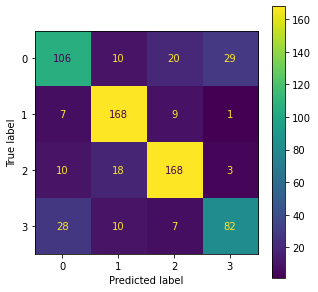

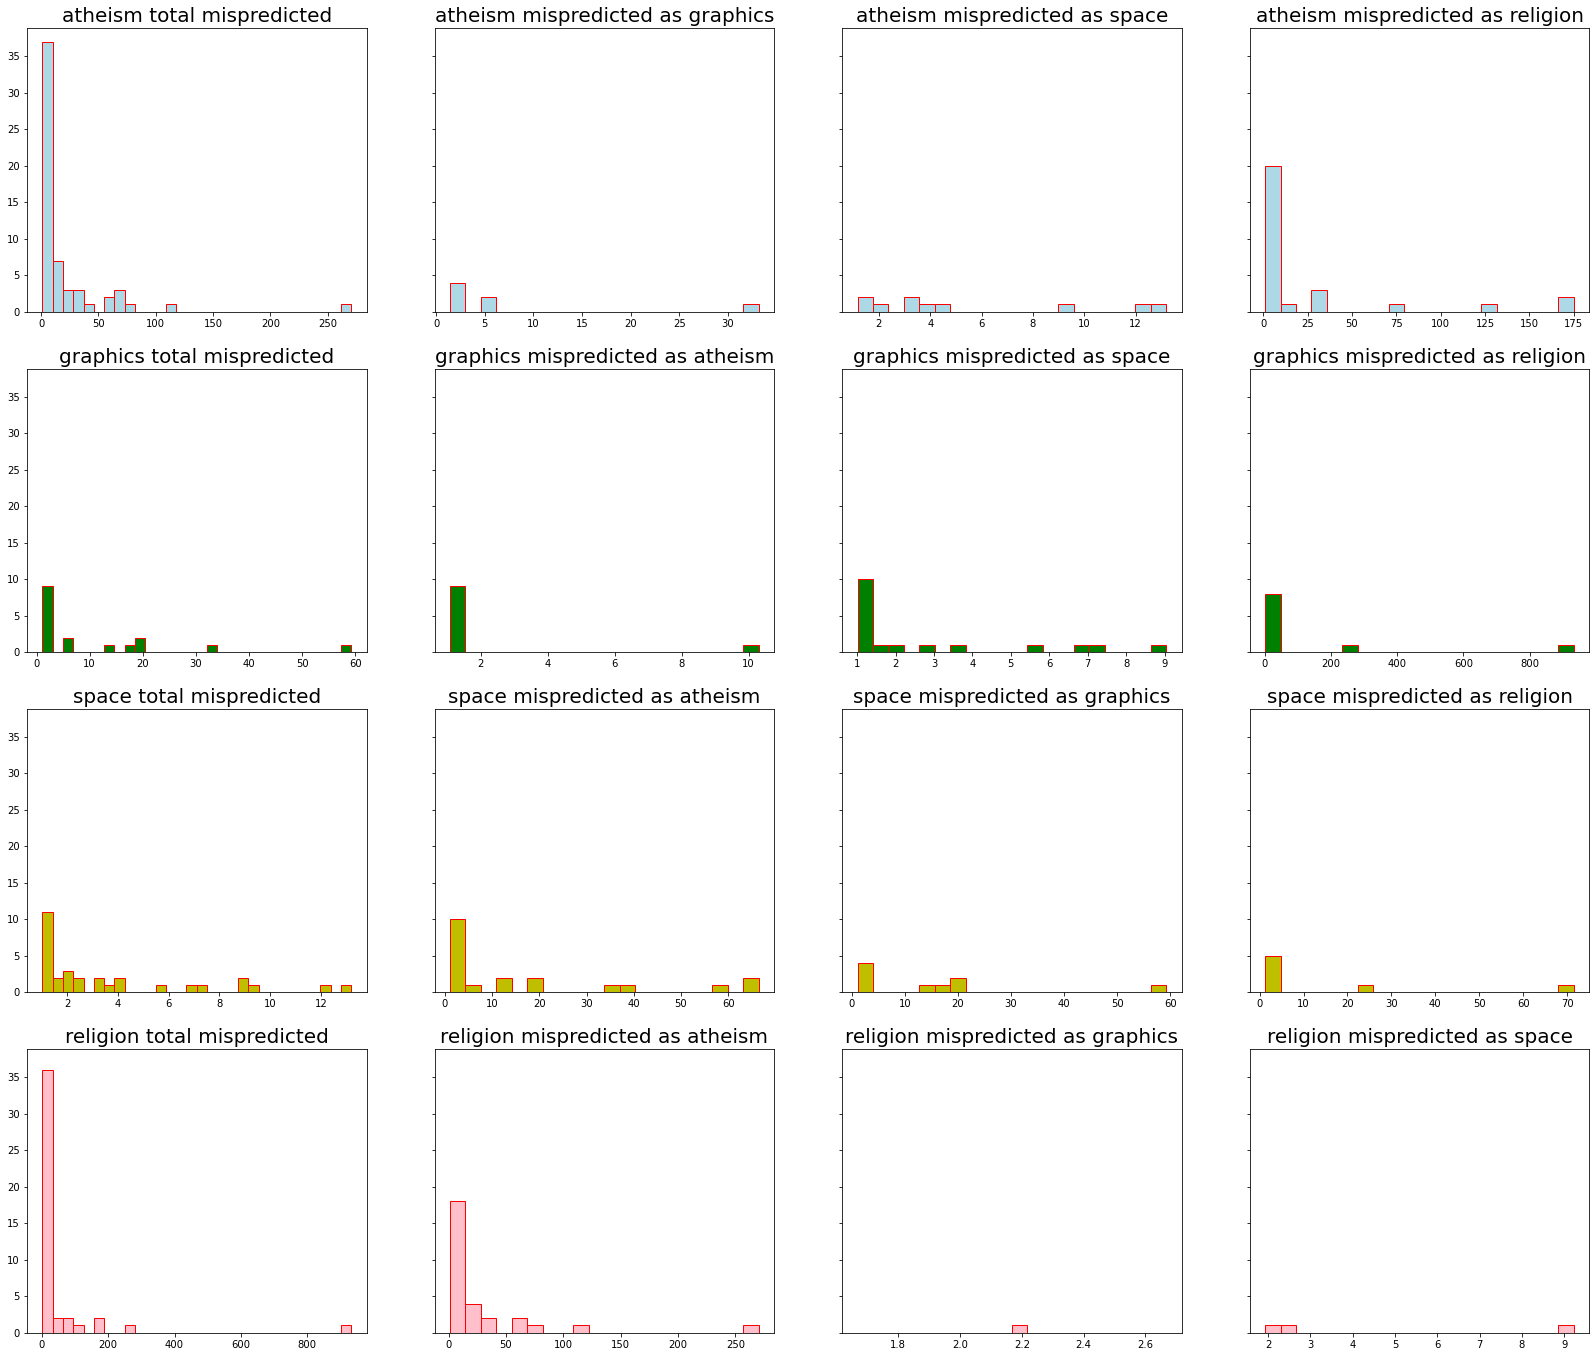

In [44]:
def P8():
### STUDENT START ###

    from sklearn.metrics import plot_confusion_matrix
 
    TFIDF = TfidfVectorizer(stop_words=  ['faith', 'believe', 'wrong', 'religious', 'against',  'bible', 'jesus', 'kent', 
                                          'life', 'should', 'even', 'may', 'really', 'world', 'reason', 'agree', 'evidence', 'rather',  
                                           'argument', 'morality', 'moral', 'statement', 'religion'])
                            
    feature_vectors_train = TFIDF.fit_transform(raw_documents=train_data)
    LR_model = LogisticRegression(  C= 100, solver="liblinear", multi_class="auto")
    LR_model.fit(feature_vectors_train, train_labels)
    feature_vectors_dev = TFIDF.transform(raw_documents=dev_data)
    dev_preds = LR_model.predict(feature_vectors_dev)
 
    accuracy = 100*metrics.accuracy_score(y_true=dev_labels, y_pred=dev_preds)
    print ('Accuracy for a Logistic Regression classifier using TfidfVectorizer: {0:.2f}%'.format(accuracy))
    
    dev_probs = LR_model.predict_proba(feature_vectors_dev)
    max_prob = dev_probs.max(axis=1)
    prob_correct_label = np.array([dev_probs[i,j] for i,j in zip(range(len(dev_labels)),dev_labels)])
    R = max_prob / prob_correct_label
    percentage = 100*len(R[R>1])/float(len(R))
    print ('Percentage of incorrectly predicted labels (R>1): {0:.2f}% (=1-Accuracy)\n'.format(percentage))
 
    
    df = pd.DataFrame(dev_labels, columns = ["dev_labels"])
    df2 = pd.DataFrame(max_prob, columns = ["max_prob"])
    df3 = pd.DataFrame(R, columns = ['R'] )
    df4 = pd.DataFrame(dev_preds, columns = ['dev_preds'] )
    df['max_prob'] =  df2['max_prob'] 
    df['R'] =  df3['R']    
    df['log_R'] = np.log(df['R'])
    df['dev_preds'] = df4['dev_preds'].astype(int)
    df['dev_labels'] = df['dev_labels'].astype(int)

    
    fig, ax = plt.subplots(figsize=(5, 5))
    plot_confusion_matrix(LR_model, feature_vectors_dev, dev_labels, ax=ax)
    plt.show()


    fig, ((ax0, ax4, ax5, ax6), (ax1, ax7, ax8, ax9), (ax2, ax10, ax11, ax12), 
          (ax3, ax13, ax14, ax15)) = plt.subplots(nrows=4, ncols=4, sharey=True, figsize=(28,24))  

    ax0.set_title('atheism total mispredicted', fontsize=20)
    ax0.hist(df[(df['dev_labels']==0) & (df['log_R']>0)]['R'],30, color = "lightblue", ec="red")
    ax1.set_title('graphics total mispredicted', fontsize=20)
    ax1.hist(df[(df['dev_labels']==1) & (df['log_R']>0)]['R'],30, color = "g", ec="red")
    ax2.set_title('space total mispredicted', fontsize=20)
    ax2.hist(df[(df['dev_labels']==2) & (df['log_R']>0)]['R'],30, color = "y", ec="red")
    ax3.set_title('religion total mispredicted', fontsize=20)
    ax3.hist(df[(df['dev_labels']==3) & (df['log_R']>0)]['R'],30, color = "pink", ec="red")
    ax4.set_title('atheism mispredicted as graphics', fontsize=20)
    ax4.hist(df[(df['dev_preds']==0) & (df['dev_labels']==1)]['R'],20, color = "lightblue", ec="red") 
    ax5.set_title('atheism mispredicted as space', fontsize=20)
    ax5.hist(df[(df['dev_preds']==0) & (df['dev_labels']==2)]['R'],20, color = "lightblue", ec="red")
    ax6.set_title('atheism mispredicted as religion', fontsize=20)
    ax6.hist(df[(df['dev_preds']==0) & (df['dev_labels']==3)]['R'],20, color = "lightblue", ec="red")
    ax7.set_title('graphics mispredicted as atheism', fontsize=20)
    ax7.hist(df[(df['dev_preds']==1) & (df['dev_labels']==0)]['R'],20, color = "g", ec="red")
    ax8.set_title('graphics mispredicted as space', fontsize=20)
    ax8.hist(df[(df['dev_preds']==1) & (df['dev_labels']==2)]['R'],20, color = "g", ec="red")
    ax9.set_title('graphics mispredicted as religion', fontsize=20)
    ax9.hist(df[(df['dev_preds']==1) & (df['dev_labels']==3)]['R'],20, color = "g", ec="red")                                   
    ax10.set_title('space mispredicted as atheism', fontsize=20)                                  
    ax10.hist(df[(df['dev_preds']==2) & (df['dev_labels']==0)]['R'],20, color = "y", ec="red")
    ax11.set_title('space mispredicted as graphics', fontsize=20)
    ax11.hist(df[(df['dev_preds']==2) & (df['dev_labels']==1)]['R'],20, color = "y", ec="red")
    ax12.set_title('space mispredicted as religion', fontsize=20)
    ax12.hist(df[(df['dev_preds']==2) & (df['dev_labels']==3)]['R'],20, color = "y", ec="red")                                   
    ax13.set_title('religion mispredicted as atheism', fontsize=20)                                                                     
    ax13.hist(df[(df['dev_preds']==3) & (df['dev_labels']==0)]['R'],20, color = "pink", ec="red")
    ax14.set_title('religion mispredicted as graphics', fontsize=20)
    ax14.hist(df[(df['dev_preds']==3) & (df['dev_labels']==1)]['R'],20, color = "pink", ec="red")
    ax15.set_title('religion mispredicted as space', fontsize=20)
    ax15.hist(df[(df['dev_preds']==3) & (df['dev_labels']==2)]['R'],20, color = "pink", ec="red")                             


### STUDENT END ###
P8()